CS512 - Computer Vision - Assignment 4 Question 1

Submitted by-

Tushar Gwal A20449419

# Question 1. Semantic Segmentation

In [1]:
# importing required Libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


# Part 1: Loading the dataset

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

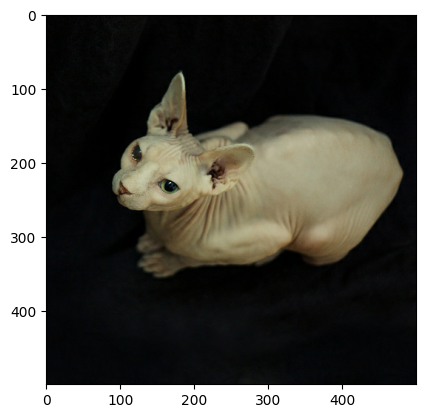

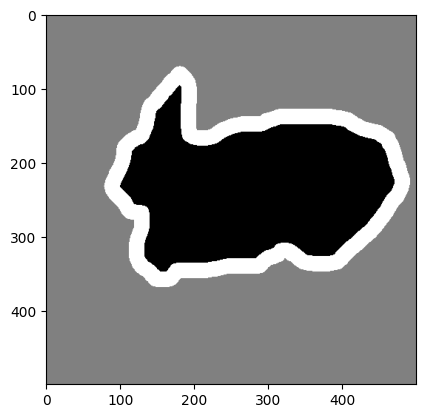

Image shape: (500, 500, 3)
Mask shape: (500, 500, 1)


In [2]:
# Loading the Oxford Pet Dataset
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
train_dataset = dataset['train']
test_dataset = dataset['test']

# Printing some basic info about the dataset
print(info)

# Displaying an image and its label for inspection
for sample in train_dataset.take(1):
    image = tf.image.convert_image_dtype(sample['image'], tf.float32)
    mask = sample['segmentation_mask']
    plt.imshow(image)
    plt.show()
    plt.imshow(mask, cmap='gray')
    plt.show()
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")

# Part 2. Preprocessing and Splitting of the Dataset

Training set size: 2576
Validation set size: 1104


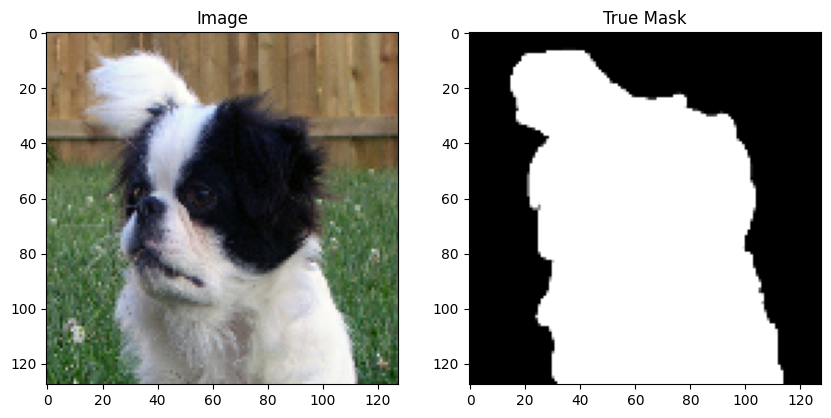

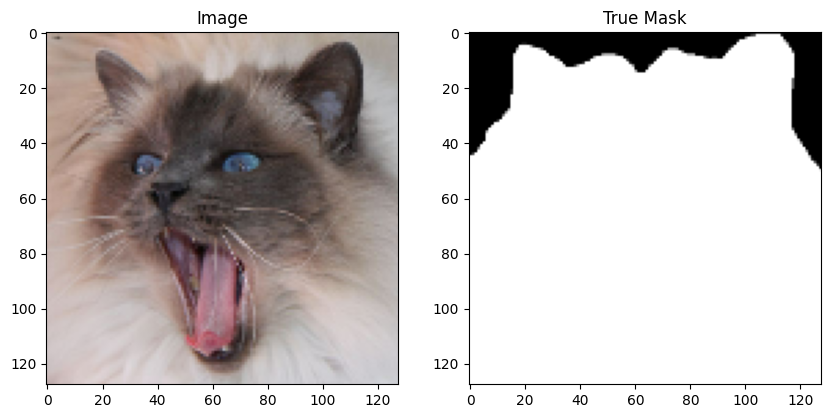

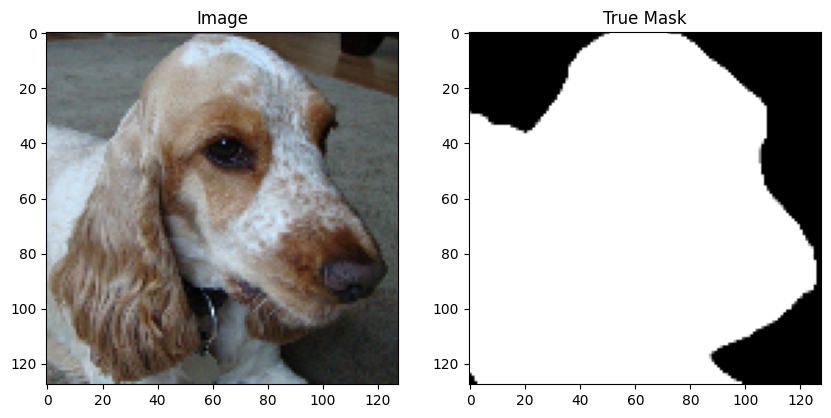

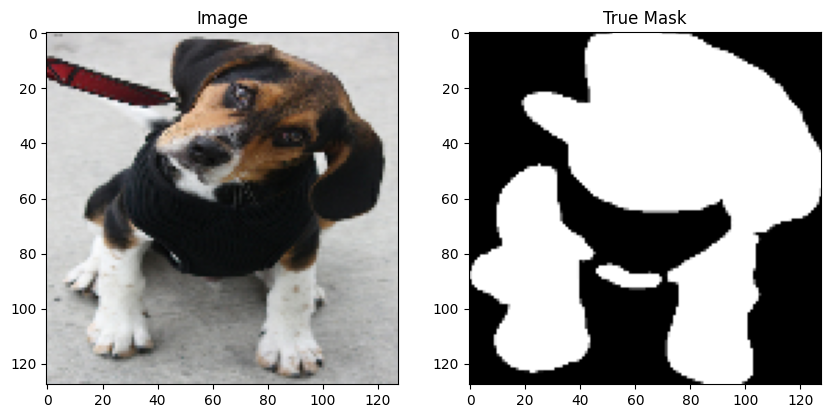

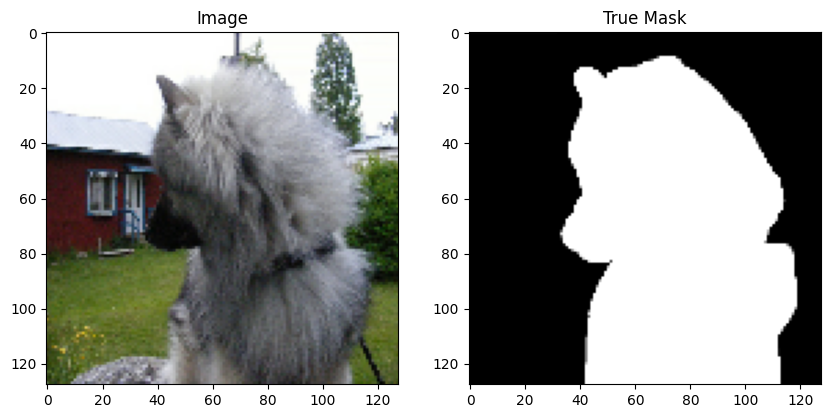

In [3]:
s = (128, 128)            # resizing size fixed

# Function for preprocessing images and masks
def preproces(x):
    i= x['image']
    m = tf.cast(x['segmentation_mask'], tf.int32)
    m = tf.where(m == 2, 0, m)  # Setting contour labels (2) to background (0)
    m = tf.where(m > 0, 1, m)   # Setting pet pixels to foreground (1)
    i = tf.image.resize(i, s)/255.0
    m = tf.image.resize(m, s)
    i = tf.image.convert_image_dtype(i, tf.float32)
    return i, m

# Applying preprocessing
train_val_dataset = train_dataset.map(preproces).cache().shuffle(1000)
test_dataset = test_dataset.map(preproces).cache().shuffle(1000)

# Spliting into training and validation datasets 70-30 ratio
train_size = int(0.7 * info.splits['train'].num_examples)
val_size = int(0.3 * info.splits['train'].num_examples)

train_dataset = train_val_dataset.take(train_size).batch(16)
val_dataset = train_val_dataset.skip(train_size).take(val_size).batch(16)
test_dataset = test_dataset.batch(16)

print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")

# Displaying a sample preprocessed image
for image, mask in train_val_dataset.take(5):
    image = image.numpy()
    mask = mask.numpy().squeeze()
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.title("True Mask")
    plt.imshow(mask, cmap='gray')
    plt.show()

# Part 3.Training a Simple CNN for Semantic Segmentation (without skip connection)

In [4]:
m1 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')
    ])

m1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
h1 = m1.fit(train_dataset, validation_data=val_dataset, epochs=30)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


161/161 ━━━━━━━━━━━━━━━━━━━━ 45s 205ms/step - accuracy: 0.6624 - loss: 0.6041 - val_accuracy: 0.7848 - val_loss: 0.4543
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7817 - loss: 0.4581 - val_accuracy: 0.8031 - val_loss: 0.4242
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7985 - loss: 0.4309 - val_accuracy: 0.8261 - val_loss: 0.3804
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8202 - loss: 0.3937 - val_accuracy: 0.8343 - val_loss: 0.3649
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8262 - loss: 0.3832 - val_accuracy: 0.8444 - val_loss: 0.3474
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8465 - loss: 0.3422 - val_accuracy: 0.8518 - val_loss: 0.3320
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8429 - loss: 0.3484 - val_accuracy: 0.8354 - val_loss: 0.3621
Epoch 8/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8469 - loss: 0.3418 - val_accuracy: 0.8

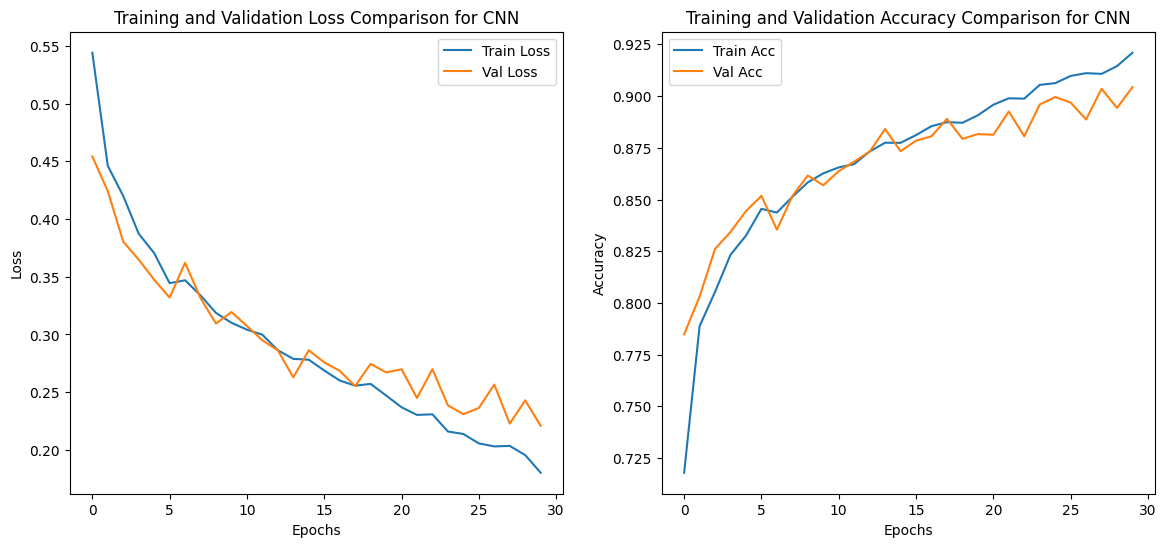

In [5]:
# Graph Plotting
plt.figure(figsize=(14, 6))

# Plotting  loss
plt.subplot(1, 2, 1)
plt.plot(h1.history['loss'], label='Train Loss')
plt.plot(h1.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison for CNN')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(h1.history['accuracy'], label='Train Acc')
plt.plot(h1.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison for CNN')
plt.legend()
plt.show()

Visualization of inference results for CNN Model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


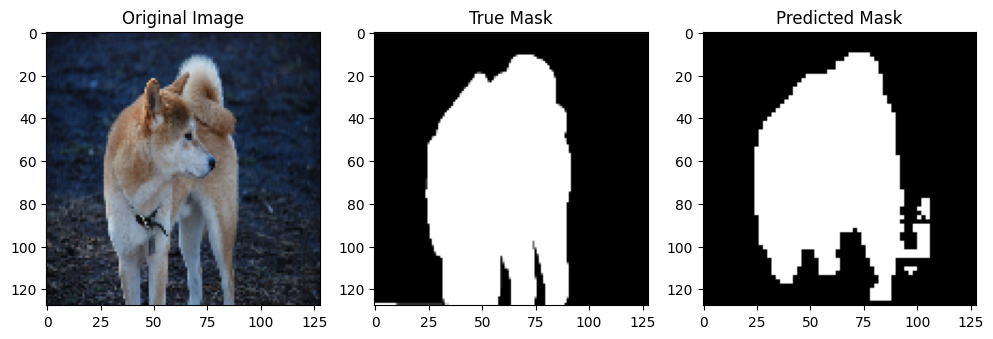

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


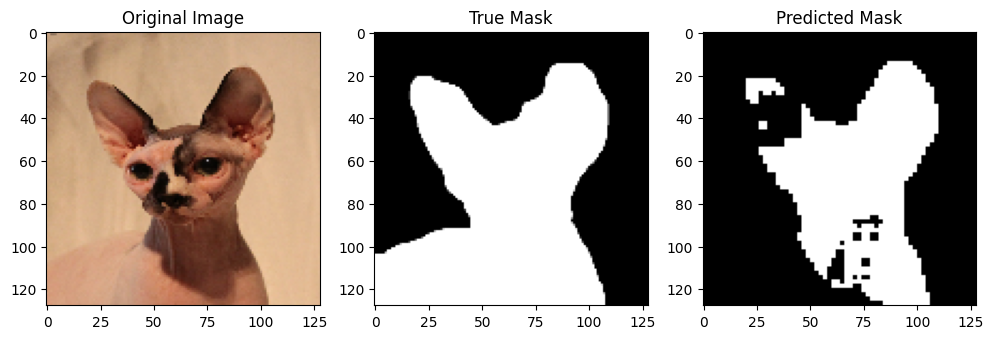

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


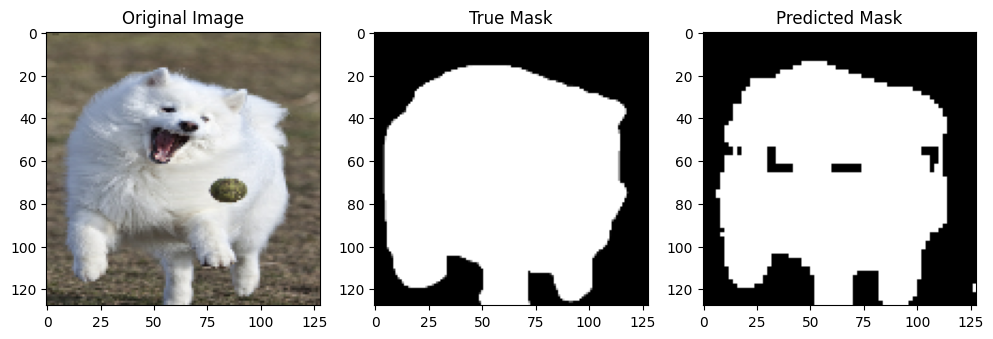

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


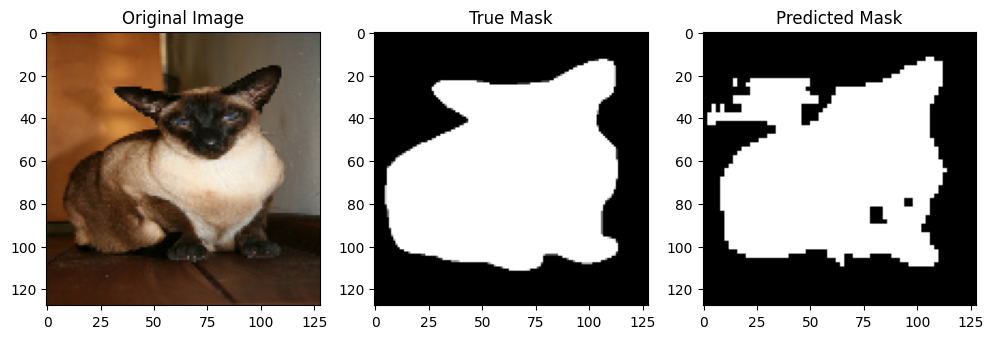

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


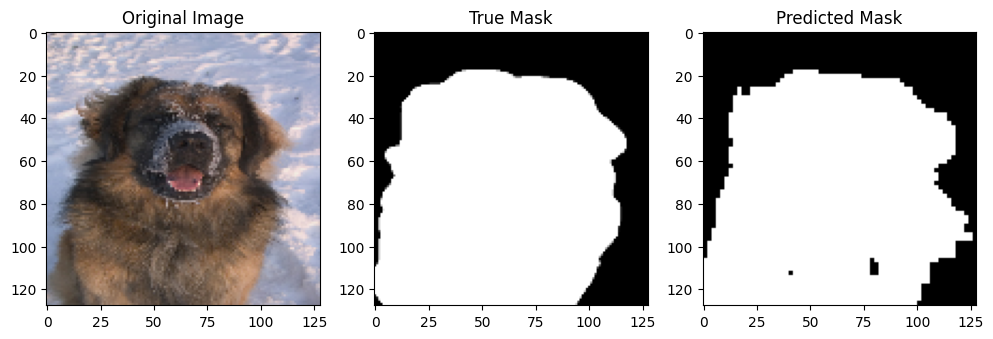

In [19]:
def visual(m, d, n=5):              # m is the model, d is the dataset, n total sample count
    sc = 0           #sc is sample count
    for bi, bm in d:                #bi and bm are batch image & batch mask
        for img, msk in zip(bi, bm):
            if sc >= n:
                return
            pm = m.predict(tf.expand_dims(img, axis=0))            # pm is predicted mask
            pm = tf.squeeze(pm) # Removing batch Dimension
            pm = tf.where(pm > 0.5, 1, 0)  #Binarize the Output
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title('Original Image')
            plt.imshow(img)
            plt.subplot(1, 3, 2)
            plt.title('True Mask')
            plt.imshow(msk, cmap='gray')
            plt.subplot(1, 3, 3)
            plt.title('Predicted Mask')
            plt.imshow(pm, cmap='gray')
            plt.show()
            sc += 1


print("Visualization of inference results for CNN Model:")
visual(m1, test_dataset)

In [7]:
# Evaluation Results for CNN model
cnn_train_ls, cnn_train_acc = m1.evaluate(train_dataset)
cnn_val_ls, cnn_val_acc = m1.evaluate(val_dataset)
cnn_test_ls, cnn_test_acc = m1.evaluate(test_dataset)

print("Evaluation Results for CNN Model:")
print(f"Training Loss: {cnn_train_ls:.4f}, Training Accuracy: {cnn_train_acc:.4f}")
print(f"Validation Loss: {cnn_val_ls:.4f}, Validation Accuracy: {cnn_val_acc:.4f}")
print(f"Testing Loss: {cnn_test_ls:.4f}, Testing Accuracy: {cnn_test_acc:.4f}")

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9224 - loss: 0.1796
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9073 - loss: 0.2157
230/230 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8743 - loss: 0.3035
Evaluation Results for CNN Model:
Training Loss: 0.1859, Training Accuracy: 0.9195
Validation Loss: 0.2216, Validation Accuracy: 0.9040
Testing Loss: 0.3027, Testing Accuracy: 0.8747


# Part 4.Training a CNN for Semantic Segmentation with skip connection (U-Net)

In [12]:
inp = tf.keras.layers.Input(shape=(128, 128, 3))
# Encoder
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

# Decoder
u3 = tf.keras.layers.UpSampling2D((2, 2))(c4)
u3 = tf.keras.layers.concatenate([u3, c3])
c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

u2 = tf.keras.layers.UpSampling2D((2, 2))(c5)
u2 = tf.keras.layers.concatenate([u2, c2])
c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

u1 = tf.keras.layers.UpSampling2D((2, 2))(c6)
u1 = tf.keras.layers.concatenate([u1, c1])
c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

out = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c7)
m2 = tf.keras.models.Model(inputs=inp, outputs=out)


m2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
h2 = m2.fit(train_dataset, validation_data=val_dataset, epochs=30)

Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.6350 - loss: 0.6159 - val_accuracy: 0.7631 - val_loss: 0.4931
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.7698 - loss: 0.4845 - val_accuracy: 0.7918 - val_loss: 0.4493
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.7936 - loss: 0.4459 - val_accuracy: 0.8171 - val_loss: 0.4055
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.8185 - loss: 0.4028 - val_accuracy: 0.8436 - val_loss: 0.3529
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.8324 - loss: 0.3730 - val_accuracy: 0.8629 - val_loss: 0.3117
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8486 - loss: 0.3405 - val_accuracy: 0.8701 - val_loss: 0.3053
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8633 - loss: 0.3127 - val_accuracy: 0.8743 - val_loss: 0.2850
Epoch 8/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8712 - loss: 0.2958 - 

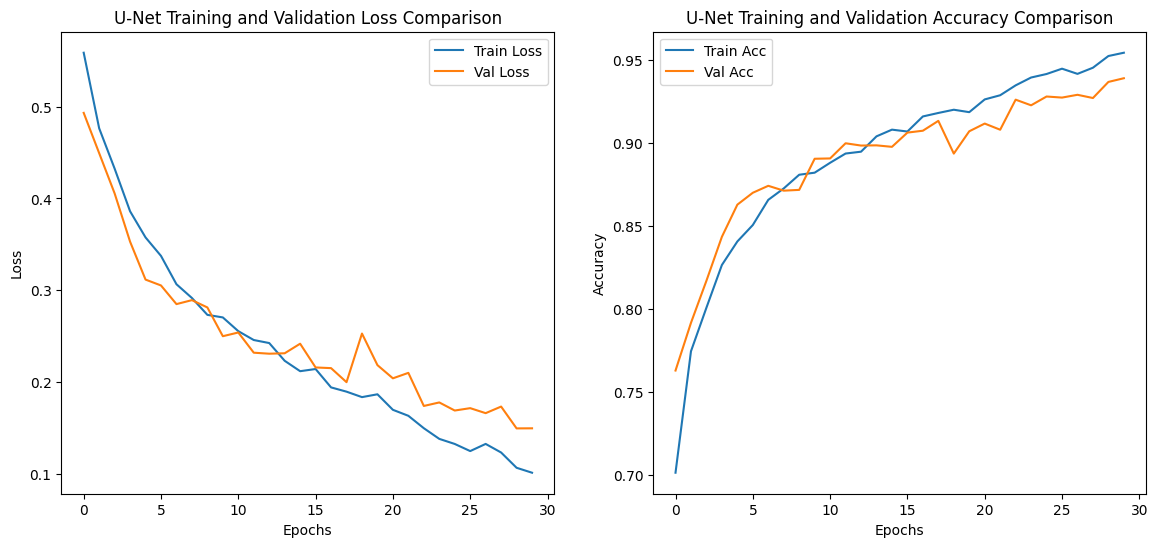

In [13]:
#Graph Plotting
plt.figure(figsize=(14, 6))

#Plot loss
plt.subplot(1, 2, 1)
plt.plot(h2.history['loss'], label='Train Loss')
plt.plot(h2.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('U-Net Training and Validation Loss Comparison')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(h2.history['accuracy'], label='Train Acc')
plt.plot(h2.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('U-Net Training and Validation Accuracy Comparison')
plt.legend()

plt.show()

Viusalization of inferernce results for U-Net Model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


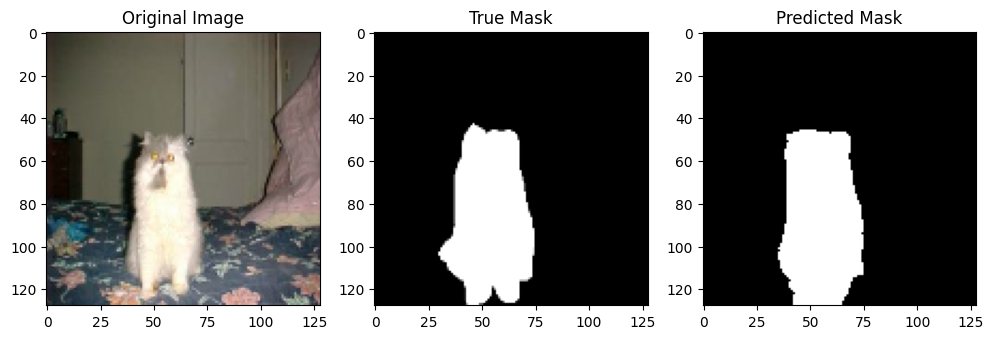

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


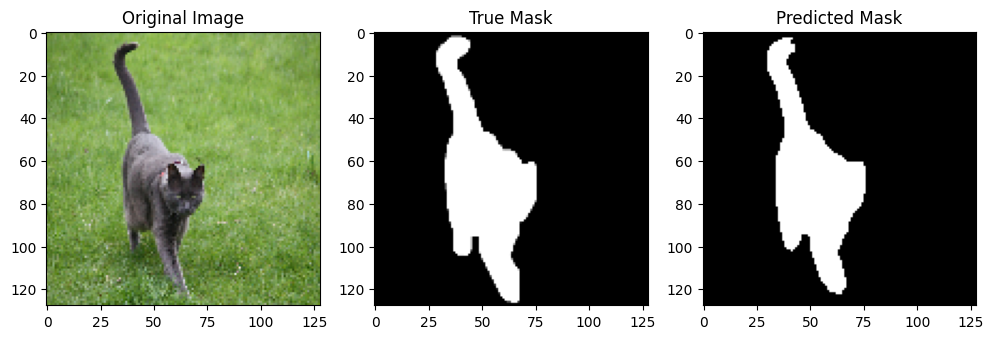

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


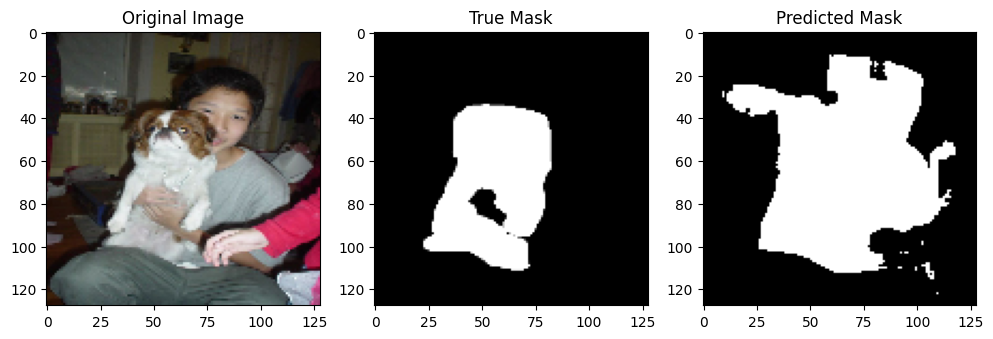

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


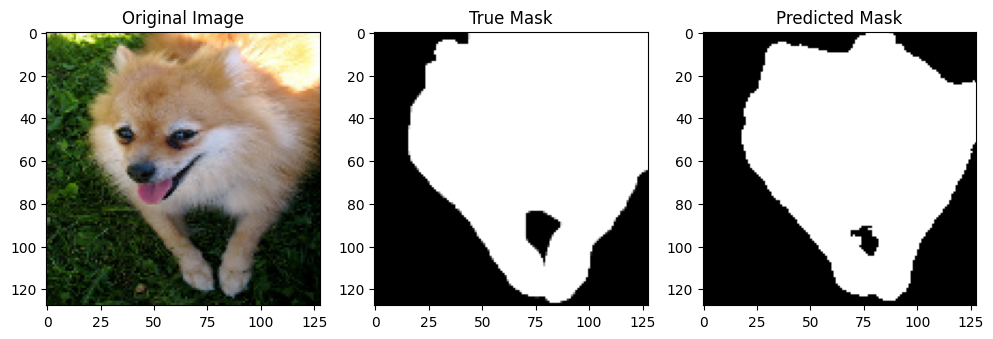

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


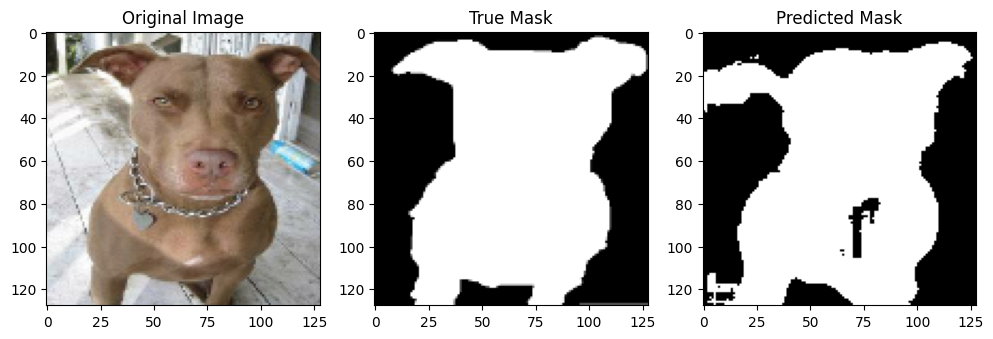

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


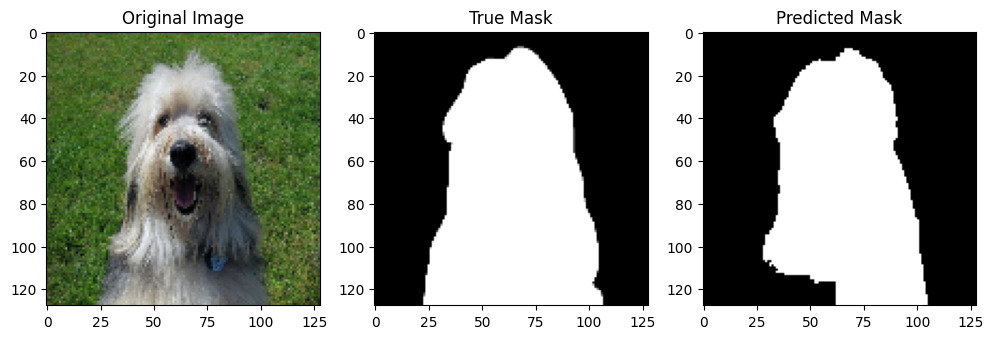

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


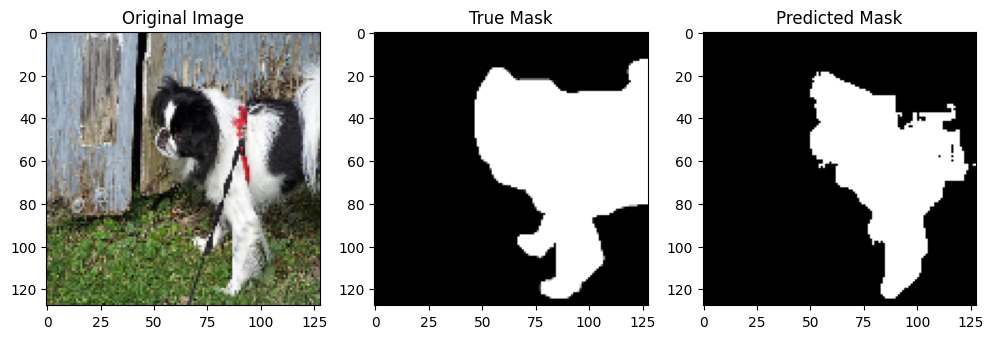

In [15]:
print("Viusalization of inferernce results for U-Net Model:")
visual(m2, test_dataset)

In [20]:
# Evaluation Results for U-net model
unet_train_ls, unet_train_acc = m2.evaluate(train_dataset)
unet_val_ls, unet_val_acc = m2.evaluate(val_dataset)
unet_test_ls, unet_test_acc = m2.evaluate(test_dataset)

print("\nEvaluation Results for U-net model:")
print(f"Training Loss: {unet_train_ls:.4f}, Training Accuracy: {unet_train_acc:.4f}")
print(f"Validation Loss: {unet_val_ls:.4f}, Validation Accuracy: {unet_val_acc:.4f}")
print(f"Testing Loss: {unet_test_ls:.4f}, Testing Accuracy: {unet_test_acc:.4f}")

161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9585 - loss: 0.0931
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9397 - loss: 0.1465
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9035 - loss: 0.2638

Evaluation Results for U-net model:
Training Loss: 0.0988, Training Accuracy: 0.9562
Validation Loss: 0.1506, Validation Accuracy: 0.9385
Testing Loss: 0.2720, Testing Accuracy: 0.9021


**Conclusion:**

The U-Net model performs better than the basic CNN model for semantic segmentation on the Oxford-IIIT Pet Dataset. This is shown by its lower loss and higher accuracy during training, validation, and testing.

The skip connections in the U-Net design are important for keeping spatial information, which helps the model capture finer details and the edges of objects. Also, the visualizations of the predicted masks show that U-Net produces clearer and more accurate segmentation results.